# Introduction

This dataset consists of bulk wave parameters and 1-D wave spectra from a collection of grid points output by the spectral wave model WAVEWATCH III. For a specific set of grid points that are colocated with the locations of real-life CDIP buoys, I extracted the bulk wave parameters output by the model. The model was run during 3 Fall months. Typically, spectral wave models model the wave spectrum but only output bulk wave parameters to save on space. However, this model run was told to output spectra at those CDIP buoy locations, which allowed me to construct this dataset with collocated bulk parameters and spectra. In the past, I've tried to use ML to predict the wave spectrum with the bulk parameters (which is a problem I would like to explore more later in this class). However, this dataset also consists of spectra representing different sea states, which I would like to investigate here.
Basically, I want to see if I can use a clustering algorithm to group wave spectra or bulk parameters by sea state. Example sea states might be:
1) Remote swell propagating in from far away,
2) A fully developed mixed sea where local winds have generated waves of all wavelength,
3) Dual wave system where two distinct wave groups are interacting at a single point.
There are many more examples of types of sea states. Each sea state will produce a unique spectral shape, and may produce distinct bulk wave parameters. My goal is to see if a clustering ML algorithm can pick up on these trends to group by sea state. My prediction is that it won't work! But it's a fun problem to explore.

The EDA notebook gives some more context into the dataset and what I set out to do with it.

In [ ]:
# for Colab users
# !pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 10.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 18.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 18.0 MB/s eta 0:00:0000:0100:01


In [268]:
import os

# data handling
import re
import xarray   as xr
import numpy    as np
import pandas   as pd

# plotting
import seaborn              as sbn
import matplotlib.pyplot    as pyp
import cartopy.crs          as ccrs
import cartopy.feature      as cfeature

# modeling
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering

import itertools

## Helper Functions

This function turns the spectrum column from a sring into an array of numbers

In [3]:
def parse_efth(entry):
    cleaned_entry = re.sub(r'[\[\]\n]', ' ', entry).strip()
    return np.array([float(value) for value in cleaned_entry.split()])

These are the true values of the frequency bins and will be used later. 

In [4]:
freqs = np.array([0.0373, 0.04103, 0.045133, 0.049646, 0.054611, 0.060072, 0.066079,
                        0.072687, 0.079956, 0.087951, 0.096747, 0.106421, 0.117063, 0.12877,
                        0.141647, 0.155811, 0.171393, 0.188532, 0.207385, 0.228123, 0.250936,
                        0.276029, 0.303632, 0.333996, 0.367395, 0.404135, 0.444548, 0.489003,
                        0.537903, 0.591694, 0.650863, 0.715949])

## Data Preparation

The data is accessed through my GitHub repo.

In [5]:
URL = 'https://raw.githubusercontent.com/colinbeyers/GEOL558-submissions/refs/heads/main/module_2/WWIII-bulk_params%2C1D_spec-fall_2021.csv'

In [6]:
df = pd.read_csv(URL)

### Parse from string to array

The data saved as a string, we need to turn the `spectrum` feature into an array.

In [7]:
df['spectrum'] = df['spectrum'].apply(parse_efth)

### Standardization

Normalization is an important preprocessing step that ensures that no one feature or spectrum is weighted unfairly versus others. There are many ways to normalize; here I will just normalize so the area under the spectrum is equal to 1.

*A suggestion was made by my project reviewer to use a standard scalar instead. I think for this kind of data, normalization makes more sense.*

In [8]:
spectra = np.stack(df['spectrum'].values)
spectra_normalized = spectra / spectra.sum(axis=1, keepdims=True)

## Clustering Exploration

The goal of this project is to see if an unsupervised ML algorithm can group spectra by their shape (which has physical meaning). First, I will just throw my data into a clustering algorithm and see how it performs. We may not necessarily need to do any crazy feature engineering if the fit is good.

### K-means

#### Model setup

We'll start with a basic model where I will guess the best number of clusters to be 4. This is based on domain knowledge; I think that the spectra would most likely be grouped into:
1) Narrow-banded swell
2) Developing seas (characterized by wind-waves)
3) Fully developed seas (characterized by a "fat" spectrum)
4) Mixed seas (where 2 wave systems have propagated away from their generation site to interact simultaneously at a given point)

In [273]:
# model initialization
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# fit
kmeans_labels = kmeans.fit_predict(spectra_normalized)

I will add the cluster label back to the original `dataframe` to we can investigate the groups visually.

In [274]:
# cluster labels
df['kmeans_label'] = kmeans_labels

#### Model evaluation

Silhouette scores range from -1 to 1, with values closer to 1 indicating better-defined clusters. A high Silhouette score means that data points within a cluster are similar to each other while being well-separated from points in other clusters. Negative scores suggest that data points may have been assigned to the wrong cluster, while scores near zero indicate overlapping clusters or ambiguous boundaries.

The Calinski-Harabasz Index, on the other hand, is a positive number where larger values indicate better-defined clusters. It evaluates clustering performance by comparing the ratio of the sum of between-cluster dispersion to within-cluster dispersion, with higher values reflecting compact and well-separated clusters. This index tends to favor solutions with distinct cluster boundaries.

In [275]:
silhouette_avg = silhouette_score(spectra_normalized, kmeans_labels)
calinski_harabasz = calinski_harabasz_score(spectra_normalized, kmeans_labels)

print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")

Silhouette Score: 0.287
Calinski-Harabasz Index: 4356.969


The silhouette score indicates that there are meaningful clusters forming. The C-H index will be given additional context once I perform a grid search.

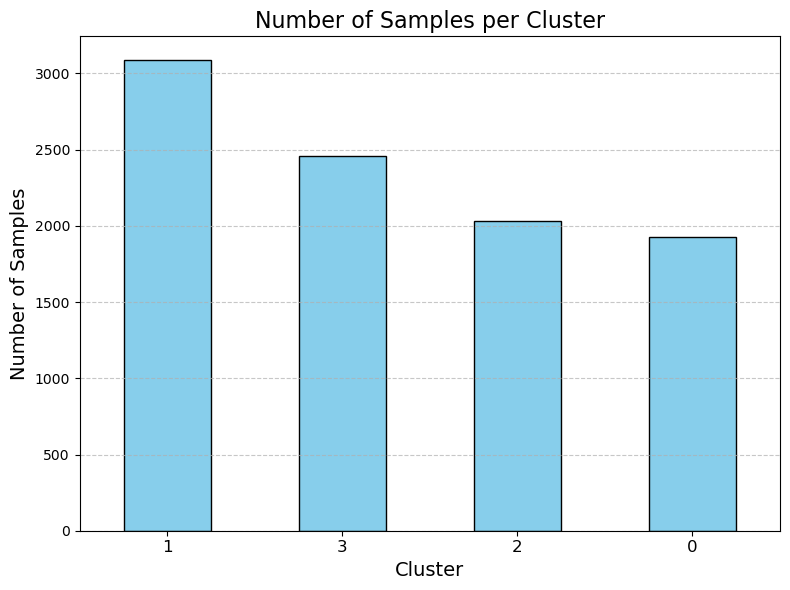

In [276]:
cluster_counts = df['kmeans_label'].value_counts()

pyp.figure(figsize=(8, 6))
cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')

pyp.title('Number of Samples per Cluster', fontsize=16)
pyp.xlabel('Cluster', fontsize=14)
pyp.ylabel('Number of Samples', fontsize=14)
pyp.xticks(rotation=0, fontsize=12)
pyp.grid(axis='y', linestyle='--', alpha=0.7)

pyp.tight_layout()
pyp.show()

The bar plot above shows how many samples were in each cluster. The clusters are not evenly sized, which makes a lot of sense. Certain types of seas are more common than others.

Visually inspecting a set of spectra from each group will help inform us what pattern the K-mean algorithm might have picked up on and what the physical explanation for each cluster might be.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


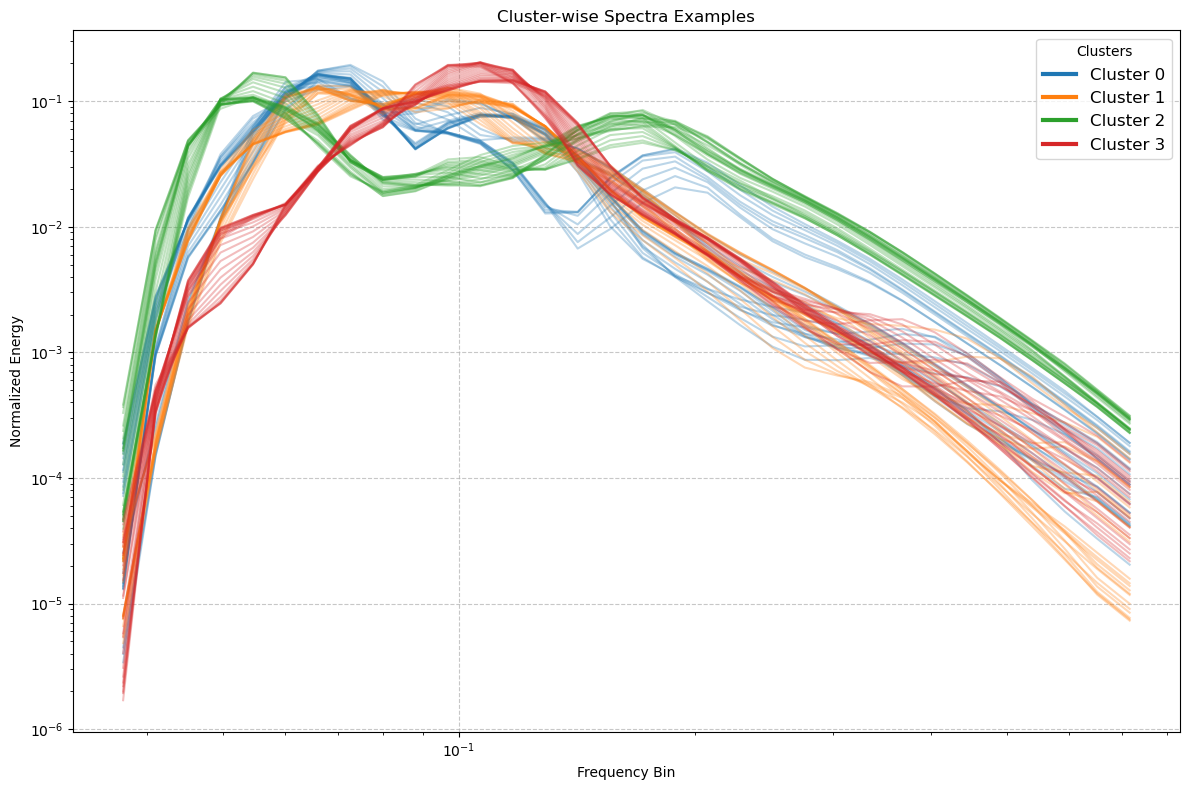

In [ ]:
# define colors for clusters
colors = pyp.cm.tab10(range(n_clusters))

# Initialize the figure
pyp.figure(figsize=(12, 8))

# iterate over each cluster
for cluster in range(n_clusters):
    cluster_samples = spectra_normalized[df['kmeans_label'] == cluster]
    for i in range(min(25, len(cluster_samples))):  # Plot up to 5 examples
        pyp.loglog(freqs, cluster_samples[i], alpha=0.3, color=colors[cluster])

# labels and legends
pyp.title('Cluster-wise Spectra Examples')
pyp.xlabel('Frequency Bin')
pyp.ylabel('Normalized Energy')
pyp.legend()
pyp.grid(True, linestyle='--', alpha=0.7)

# legend
handles = [pyp.Line2D([0], [0], color=colors[cluster], lw=3, label=f'Cluster {cluster}') for cluster in range(n_clusters)]
pyp.legend(handles=handles, title='Clusters', loc='upper right', fontsize=12)

# show
pyp.tight_layout()
pyp.show()

- The green cluster is definitely a grouping of mixed seas. This is indicated by the 2 distinct spectral peaks.
- Red seems to be a grouping of developing seas - there is a peak of energy at higher frequencies, but a lack of energy at low frequencies (which take longer to generate). 
- Orange and blue are hard to discern from each other. However, orange seems to be pretty wide and smooth, which might indicate fully developed seas. Blue does not seem to line up with narrow banded spectra. 

An exploration of the bulk wave parameters later might help give context to these clusters.

#### Grid search for ideal number of clusters

Before, I simply guessed that 4 clusters would be best. Now we will perform a grid search and assess the scores from 2-10 clusters.

In [12]:
cluster_range = range(2, 11)
silhouette_scores = []
ch_scores = []

In [13]:
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(spectra_normalized)
    
    # Calculate metrics
    silhouette_scores.append(silhouette_score(spectra_normalized, cluster_labels))
    ch_scores.append(calinski_harabasz_score(spectra_normalized, cluster_labels))

We can plot the metrics across number of clusters.

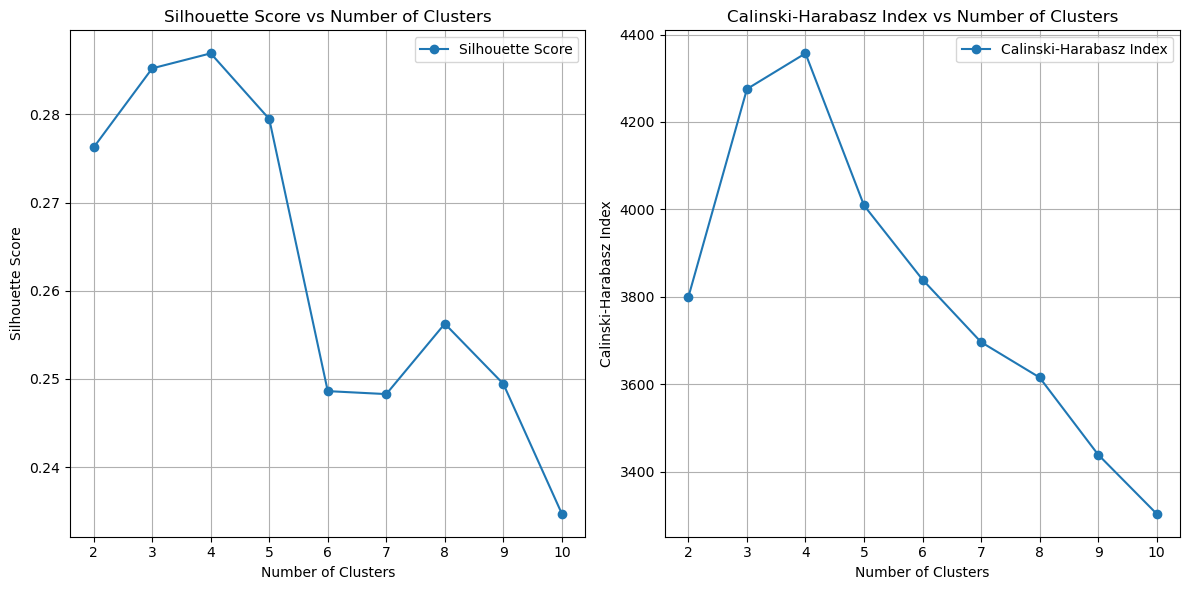

In [14]:
pyp.figure(figsize=(12, 6))

# silhouette score
pyp.subplot(1, 2, 1)
pyp.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette Score')
pyp.title('Silhouette Score vs Number of Clusters')
pyp.xlabel('Number of Clusters')
pyp.ylabel('Silhouette Score')
pyp.grid(True)
pyp.legend()

# Calinski-Harabasz index
pyp.subplot(1, 2, 2)
pyp.plot(cluster_range, ch_scores, marker='o', label='Calinski-Harabasz Index')
pyp.title('Calinski-Harabasz Index vs Number of Clusters')
pyp.xlabel('Number of Clusters')
pyp.ylabel('Calinski-Harabasz Index')
pyp.grid(True)
pyp.legend()

pyp.tight_layout()
pyp.show()

As hypothesized, 4 was the ideal number of clusters for both metrics. One interesting point though is that the silhouette score doesn't actually change by much - even at 10 clusters, the score is not much different than when there were 4 groups. I imagine this is because there are many spectra that can be placed well in more than one cluster. The C-H score changes more dramatically, giving some confidence in the choice of 4 clusters.

### GMM

The Gaussian Mixture Model might provide a better fit beacause it allows for different cluster shapes. Similar to before, we'll start with 4 clusters.

In [15]:
n_clusters = 4  

gmm = GaussianMixture(n_components=n_clusters, covariance_type='tied', random_state=42)
gmm_labels = gmm.fit_predict(spectra_normalized)

df['gmm_label'] = gmm_labels

In [16]:
silhouette_avg = silhouette_score(spectra_normalized, gmm_labels)
calinski_harabasz = calinski_harabasz_score(spectra_normalized, gmm_labels)

print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")

Silhouette Score: 0.257
Calinski-Harabasz Index: 3356.660


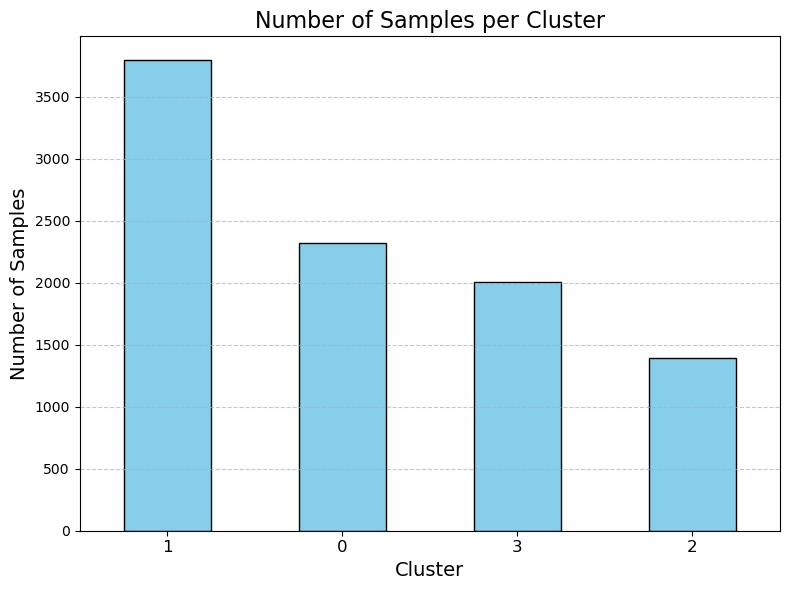

In [17]:
cluster_counts = df['gmm_label'].value_counts()

pyp.figure(figsize=(8, 6))
cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')

pyp.title('Number of Samples per Cluster', fontsize=16)
pyp.xlabel('Cluster', fontsize=14)
pyp.ylabel('Number of Samples', fontsize=14)
pyp.xticks(rotation=0, fontsize=12)
pyp.grid(axis='y', linestyle='--', alpha=0.7)

pyp.tight_layout()
pyp.show()

As before, the groups are unevenly sized. The groups are different sizes than from the K-mean algorithm, though. This indicates to me that some spectra are placed into different groups than before.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


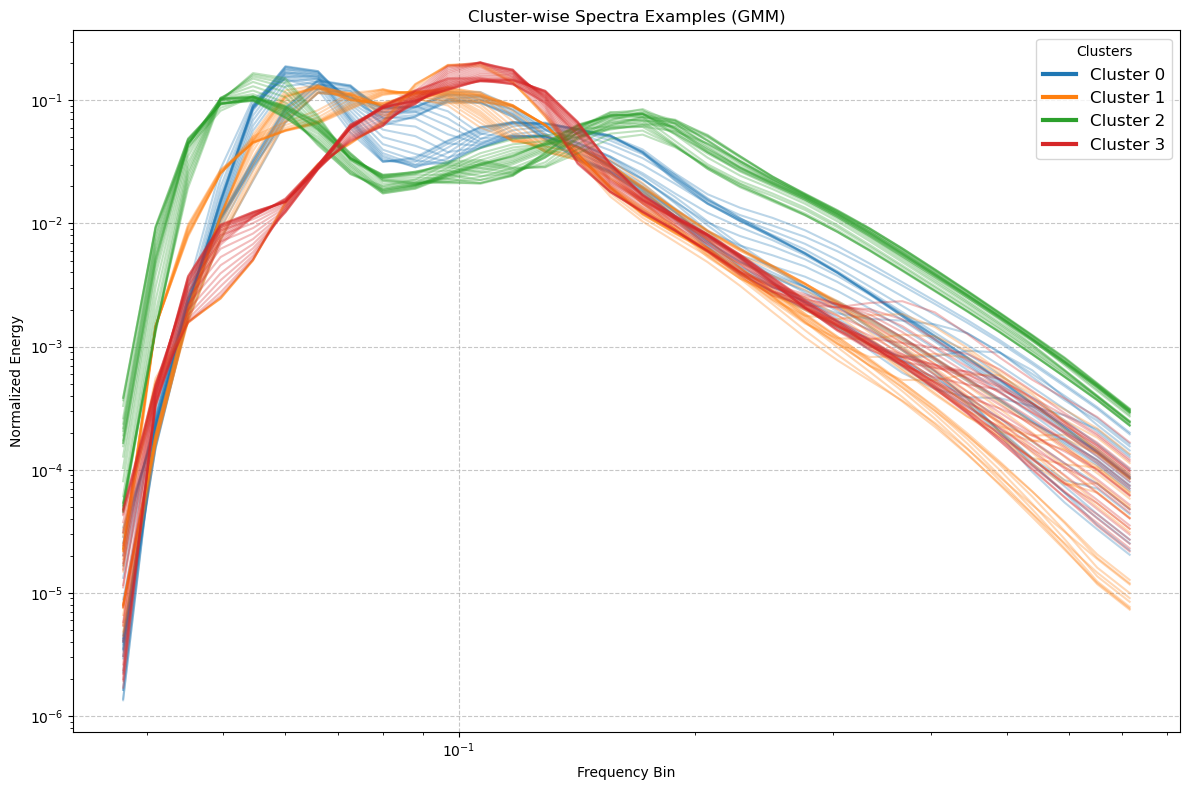

In [278]:
colors = pyp.cm.tab10(range(n_clusters))

pyp.figure(figsize=(12, 8))

for cluster in range(n_clusters):
    cluster_samples = spectra_normalized[df['gmm_label'] == cluster]

    for i in range(min(25, len(cluster_samples))):
        pyp.loglog(freqs, cluster_samples[i], alpha=0.3, color=colors[cluster])

pyp.title('Cluster-wise Spectra Examples (GMM)')
pyp.xlabel('Frequency Bin')
pyp.ylabel('Normalized Energy')
pyp.legend()
pyp.grid(True, linestyle='--', alpha=0.7)

# legend
handles = [pyp.Line2D([0], [0], color=colors[cluster], lw=3, label=f'Cluster {cluster}') for cluster in range(n_clusters)]
pyp.legend(handles=handles, title='Clusters', loc='upper right', fontsize=12)

pyp.tight_layout()
pyp.show()

While the GMM model may have placed spectra into different clusters, the categories of the spectra seem very similar to before.

The GMM model performed slightly worse than the K-means model, but we haven't tuned it yet! I will again try different numbers of clusters (2-10) but also test out different cluster shapes with the covariance types.

In [19]:
# define parameter grid for hyperparameters
n_components_range = range(2, 11)  # Test from 2 to 10 components
covariance_types = ['full', 'tied', 'diag', 'spherical']

results = []

# generate all combinations of hyperparameters
param_grid = itertools.product(n_components_range, covariance_types)

# grid search
for n_components, covariance_type in param_grid:
    gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
    
    gmm.fit(spectra_normalized)
    cluster_labels = gmm.predict(spectra_normalized)
    
    silhouette = silhouette_score(spectra_normalized, cluster_labels)
    ch_index = calinski_harabasz_score(spectra_normalized, cluster_labels)
    
    # Store results
    results.append((n_components, covariance_type, silhouette, ch_index))

results_df = pd.DataFrame(results, columns=['n_components', 'covariance_type', 
                                            'silhouette_score', 'calinski_harabasz_index'])

The results for each model and its parameters was placed into a `dataframe` to make things easier to sort.

In [20]:
best_model = results_df.sort_values(by='silhouette_score', ascending=False).iloc[0]
best_model

n_components                         4
covariance_type              spherical
silhouette_score              0.267563
calinski_harabasz_index    4174.711258
Name: 11, dtype: object

In [21]:
best_model = results_df.sort_values(by='calinski_harabasz_index', ascending=False).iloc[0]
best_model

n_components                         4
covariance_type              spherical
silhouette_score              0.267563
calinski_harabasz_index    4174.711258
Name: 11, dtype: object

I looked for the best model in terms of both the silhouette score and the C-H index. The scores were highest in the same model.

The best GMM model has 4 clusters and a spherical covariance type. This is essentially the same as the K-means model (which assumes spherical clusters). It's scores support this as they are basically the same as the K-means model.

## PCA

*As suggested by my reviewer, PCA didn't make much sense to use here. Instead, I will try 1 more clustering algorithm.*

## Spectral Clustering

At first, I tried using the DBScan clustering algorithm. After some trial and error, I was not getting very promising results. After reading up a little bit on DBSscan, I decided it was not really an appropriate algorithm for clustering the shape of curves.

Instead, I will try the Spectral Clustering algorithm. This method can be used when data can be represented in a graph structure, especially useful for clustering in cases where distance metrics are less informative.

For this model, I will try starting with a grid search to look at all the different hyperparameter options. WARNING: this cell may take a while to run. I had to manually loop through each parameter because I was having problems with `scikitlearn`'s grid search function.

In [ ]:
# Define a custom function to compute silhouette score
def silhouette_scorer(X, labels):
    return silhouette_score(X, labels)

# Initialize the SpectralClustering model
spectral_model = SpectralClustering(random_state=42)

# Define the hyperparameter grid for Spectral Clustering
param_grid = {
    'n_clusters': [2, 3, 4, 5, 6],
    'affinity': ['nearest_neighbors', 'rbf', 'cosine'],
    'n_neighbors': [5, 10, 15],
    'gamma': [0.1, 1, 10],
}

# Manually iterate over parameter grid for tuning and scoring

best_silhouette = -np.inf
best_params = None

# Grid search over hyperparameters
for n_clusters in param_grid['n_clusters']:
    print("I am on iteration", n_clusters - 1, "out of 5.")
    for affinity in param_grid['affinity']:
        for n_neighbors in param_grid['n_neighbors']:
            for gamma in param_grid['gamma']:
                # Create the SpectralClustering model with current parameters
                model = SpectralClustering(n_clusters=n_clusters, affinity=affinity, 
                                           n_neighbors=n_neighbors, gamma=gamma, random_state=42)

                # Fit the model and predict the labels
                labels = model.fit_predict(spectra_normalized)

                # Compute silhouette score
                silhouette_avg = silhouette_score(spectra_normalized, labels)

                # Check if this is the best silhouette score so far
                if silhouette_avg > best_silhouette:
                    best_silhouette = silhouette_avg
                    best_params = {
                        'n_clusters': n_clusters,
                        'affinity': affinity,
                        'n_neighbors': n_neighbors,
                        'gamma': gamma
                    }

# Print best parameters and silhouette score
print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score: {best_silhouette}")

2
3
4
5
6
Best Parameters: {'n_clusters': 3, 'affinity': 'rbf', 'n_neighbors': 5, 'gamma': 10}
Best Silhouette Score: 0.2832992486957953


Interestingly, this model's best results was with 3 clusters. Below, I will assign the labels for the best model to the `dataframe`.

In [258]:
# Best parameters
n_clusters = 3
affinity = 'rbf'
n_neighbors = 5
gamma = 10

# Initialize the model
spectral_clustering = SpectralClustering(
    n_clusters=n_clusters, 
    affinity=affinity, 
    n_neighbors=n_neighbors, 
    gamma=gamma, 
    random_state=42
)

# Fit the model and assign labels
spectral_labels = spectral_clustering.fit_predict(spectra_normalized)

# Assign the labels to the dataframe
df['spectral_label'] = spectral_labels

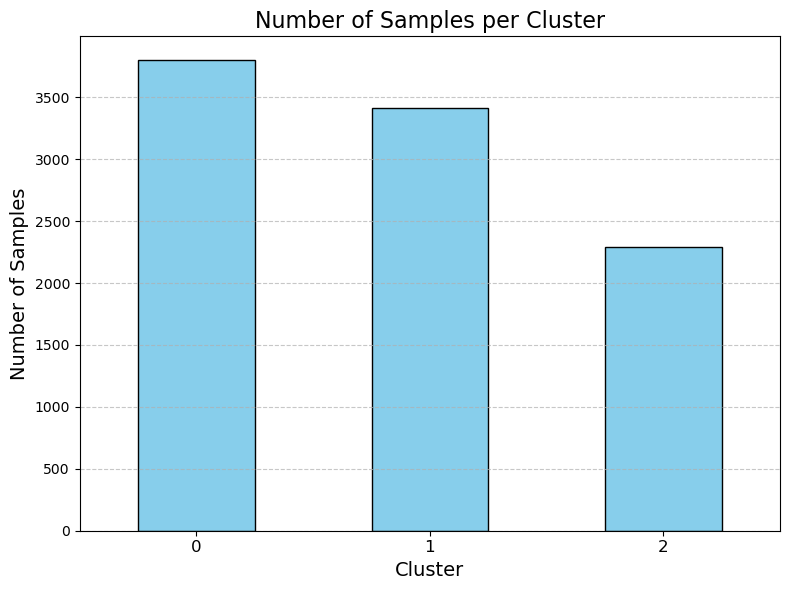

In [ ]:
# Assuming 'df' is your dataframe and 'spectral_label' contains the cluster labels
cluster_counts = df['spectral_label'].value_counts()

# Plot the bar chart
pyp.figure(figsize=(8, 6))
cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add title and labels
pyp.title('Number of Samples per Cluster', fontsize=16)
pyp.xlabel('Cluster', fontsize=14)
pyp.ylabel('Number of Samples', fontsize=14)

# Customize the ticks and grid
pyp.xticks(rotation=0, fontsize=12)
pyp.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
pyp.tight_layout()
pyp.show()

Similar to before, the cluster sizes are uneven. None of these clusters seem odd to me (i.e., none are very small or very large compared to the others).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


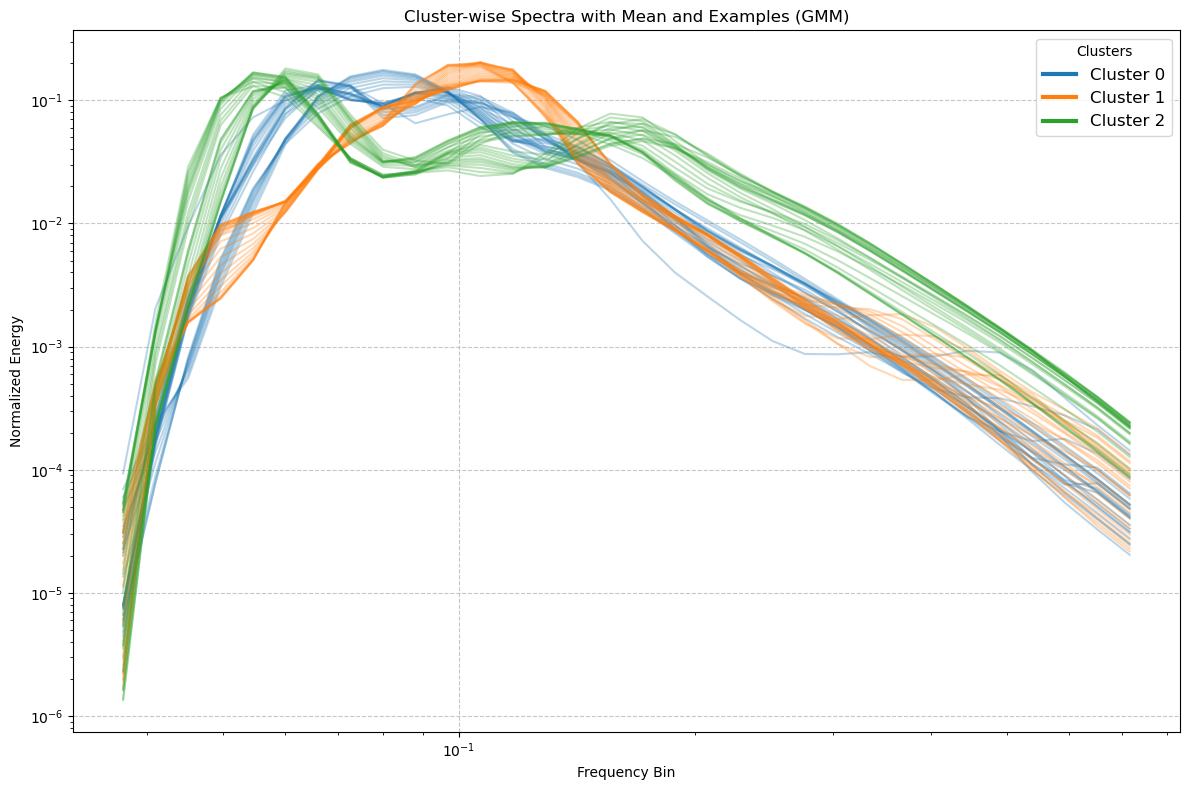

In [270]:
colors = pyp.cm.tab10(range(3))

pyp.figure(figsize=(12, 8))

for cluster in range(n_clusters):
    cluster_samples = spectra_normalized[df['spectral_label'] == cluster]

    for i in range(min(25, len(cluster_samples))):
        pyp.loglog(freqs, cluster_samples[i], alpha=0.3, color=colors[cluster])

pyp.title('Cluster-wise Spectra with Mean and Examples (GMM)')
pyp.xlabel('Frequency Bin')
pyp.ylabel('Normalized Energy')
pyp.legend()
pyp.grid(True, linestyle='--', alpha=0.7)

# legend
handles = [pyp.Line2D([0], [0], color=colors[cluster], lw=3, label=f'Cluster {cluster}') for cluster in range(n_clusters)]
pyp.legend(handles=handles, title='Clusters', loc='upper right', fontsize=12)

pyp.tight_layout()
pyp.show()

While the orange and green group are similar to groups we saw before, the blue group seems to consists of 2 different spectral shapes. While before I commented that there were two groups that seemed similar, here when they are the same color, I think they should be clustered separately.

## Short Discussion

### Which method did you like the most?

I liked the K-means algorithm the best. It was easy to operate and the assumptions that it makes (i.e., spherical cluster shapes) ended up providing a good fit with clusters that looked physically meaningful.

### Which method did you like the least?

I liked spectral clustering the least. While I have learned about the other models in a class, I did not know much about this model. I was less familiar with this model's hyperparameters, which made deciding on appropriate parameters difficult. The result from this model are also different from the other two, making me unsure about my results. 

### How did you score these unsupervised models?  


I used the silhouette score and the Calinski-Harabasz Index. Details on those metrics were provided above. I also looked at example spectra for each group to use my domain knowledge to assess if the groups looked physically meaningful.

### Did the output align with your geologic (oceanographic) understanding?

The clusters that were formed by the K-means algorithm seem physically sound. The first line plot that was produced shows 4 groups that I would characterize as:
- Red: developing seas. There is 1 spectral peak, but it is at a higher frequency than say, the orange curves. This indicates that local winds have been generating waves, but have not been blowing long enough to form long-wave, low frequency swell.
- Orange: developed seas. On the contrary, the orange spectra are wide with a single peak at a lower frequency than the red spectra. This indicates that the winds have been blowing long enough the generate long-wave swell, while short waves are also present in the system.
- Green: mixed seas. The two spectral peaks indicate that there are more than one distinct wave systems interacting at this point.
- Blue: unsure. These spectra are hard to characterize. Some of them seem to have two peaks, but the shape is intrinsically different than the green spectra. Perhaps, blue and green both represent mixes seas, but the green spectra indicate wave systems that were generated far away and propagated in, while the blue spectra indicates regionally generated wave systems that have propagated to the buoy location. This is supported bt the fact that the spectral peaks in the green group are much more narrow, indicated waves that have been well sorted by wave-dispersion.

### What did you want to learn more about?

I want to learn more about other models that are best suited for grouping curves by shape. These include Self-Organizing Maps (SOM), Hierarchical Clustering, and Dynamic Time Warping (DTW), which is not a model, but a different way of calculating distances for high-dimension data. I also want to learn more about the parameter space of each group and to see if they are distinct. This could be achieved by looking at other wave paramters in the `dataframe` and comparing them across groups.

### Did you pre-process your data?

I did a lot of preprocessing when I originally developed the data. This included taking the data from the wave model and sorting it into a `dataframe` for the few grid points that I was interested in. I also had to convert the 2D spectra to a 1D spectra. For this project, I had to parse the data to be the right type and had to normalize it.

### What was a decision you were most unsure about?

I am unsure if the models I chose are best suited for this task. There are many other unsupervised learning techniques that can be used to cluster curves based off of shape. I tried a few of these, but they were much more difficult to operate. Furthermore, there are some distance metrics that can account for how the curve changes over time that may be better at determining what curve belongs in what cluster. These different distance metrics can be used to compute distances between curves better than Euclidean distance. Ultimately, it was hard to determine which unsupervised algorithm was the best move. I am unsure if my results would have meaningfully improved with a more complex algorithm because spectra tend to all have similar shapes (they all look like of like a skewed bell curve) with variations depending on the wave conditions.